In [1]:
#models = ['GIN', 'GAT', 'GCNN', 'GatedGCNN']
# note, no twitter.
datasets = ["RANDOM",'ENZYMES', 'PROTEINS', 'IMDB-BINARY', 'MUTAG', 'COLLAB']
run_folders = ['230928_runs/230925_TUsmall_GAT_VC', '230928_runs/230925_TUsmall_GIN_cut', 
               '230928_runs/230925_generated_preset_cut', '230928_runs/230925_TUsmall_GAT_cut', 
               '230928_runs/230925_TUsmall_liftMP_cut', '230928_runs/230925_TUsmall_GCNN_VC', 
               '230928_runs/230925_TUsmall_GCNN_cut', '230928_runs/230925_generated_liftMP_VC', '230928_runs/230925_generated_preset_VC', 
               '230928_runs/230925_TUsmall_liftMP_VC', '230928_runs/230925_TUsmall_GatedGCNN_VC', '230928_runs/230925_TUsmall_VC_32', 
               '230928_runs/230925_TUlarge_liftMP_cut', '230928_runs/230925_TUlarge_liftMP_VC', '230928_runs/230925_generated_liftMP_cut', '230928_runs/230925_TUsmall_GatedGCNN_cut']
params = ['num_layers', 'rank', 'positional_encoding',]

In [2]:
import json
import pandas as pd
import numpy as np
import os

task = 'max_cut'

folder_path = '/home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs'
model_list = [os.path.join(folder_path, run_folder, x) for run_folder in run_folders for x in os.listdir(os.path.join(folder_path, run_folder))  ]


rows = []

errored = []
for model_folder in model_list:
    try:
        with open(os.path.join(model_folder, 'params.txt'), 'r') as f:
            model_args = json.load(f)
        if model_args['problem_type'] != task:
            continue
        
        losses = np.load(os.path.join(model_folder, 'valid_scores.npy'))
        test_losses = np.load(os.path.join(model_folder, 'test_scores.npy'))

        modeldict = model_args #{x: model_args[x] for x in params}
        modeldict['max_valid_score'] = max(losses)
        modeldict['max_valid_epoch'] = np.argmax(losses)
        modeldict['scores'] = test_losses[np.argmax(losses)]
        modeldict['baseline'] = False


        # set the time per pred
        time_per_pred = None
        scorefile = [x for x in os.listdir(model_folder) if x.startswith('retest_best')]
        if len(scorefile) >= 1:
            times, _ = np.load(os.path.join(model_folder, scorefile[-1]))
            time_per_pred = np.average(times)
        modeldict['time_per_pred'] = time_per_pred


        # reset test score if the validation is better.
        valid_score_from_file = -np.inf
        test_score_from_file = -np.inf

        for prefix in ['revalidate_best', 'revalidate_last']:
            scorefile = [x for x in os.listdir(model_folder) if x.startswith(prefix)]
            #assert(len(scorefile) <=1)
            if len(scorefile) >= 1:
                _, scores = np.load(os.path.join(model_folder, scorefile[-1]))
                valid_score = np.average(scores)

                if valid_score > valid_score_from_file:
                    testscorefile = [x for x in os.listdir(model_folder) if x.startswith(prefix.replace('validate', 'test'))]
                    _, test_scores =  np.load(os.path.join(model_folder, testscorefile[0]))
                    test_score_from_file = np.average(test_scores)
                    valid_score_from_file = valid_score
        

                        
        if valid_score_from_file > modeldict['max_valid_score']:
            modeldict['max_valid_score'] = valid_score_from_file
            modeldict['scores'] = test_score_from_file
        #if model_args['dataset'].startswith('REDDIT'):
        #    print(modeldict['max_valid_score'], test_score_from_file)
        rows.append(modeldict)
        
    except Exception as e:
        print(f'{e} is wrong w/ {model_folder}')
        errored.append(model_folder)

In [3]:
#rows.append({'dataset': 'Dummy',
#             'scores': 0})

In [4]:
df = pd.DataFrame.from_records(rows)

In [5]:
df = df.fillna("None")

df.sort_values('scores', ascending = False)

In [6]:
import seaborn as sns

In [7]:
pe_dict = {'laplacian_eigenvector': 'LE', 'random_walk': 'RW'}
df.positional_encoding = df.positional_encoding.apply(lambda x: pe_dict.get(x, x))

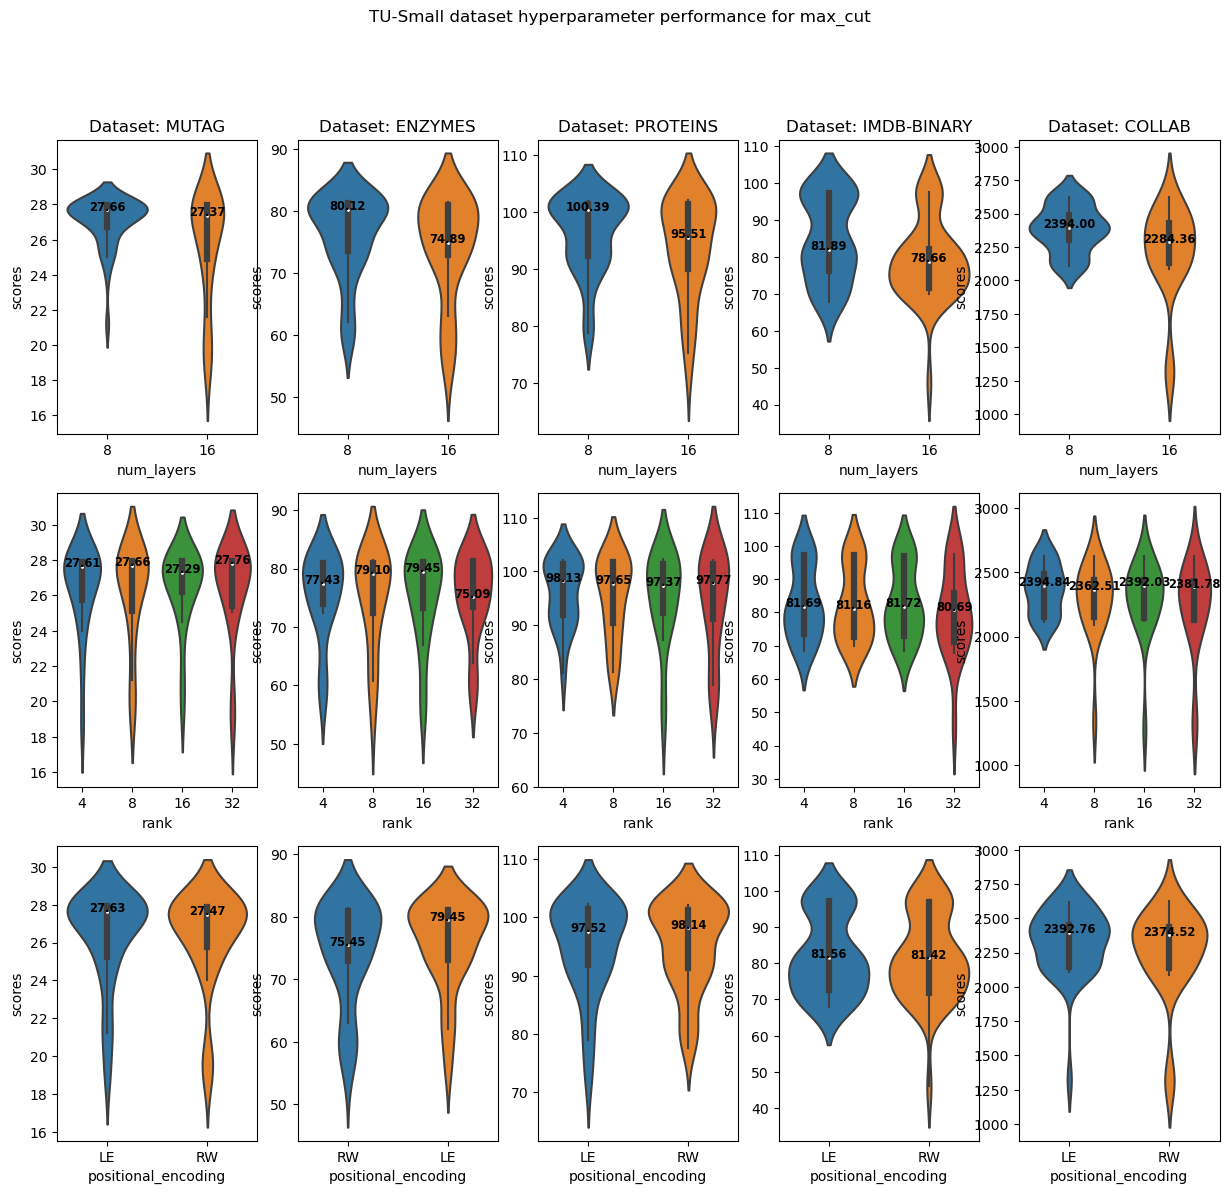

In [8]:
# hparams in rows
# datasets in colums
rows = [x for x in params if x not in ["dataset", 'vc_penalty']]
columns = ['MUTAG', 'ENZYMES', 'PROTEINS',   'IMDB-BINARY', 'COLLAB'] #set(df.dataset).union(set("Dummy"))
import matplotlib.pyplot as plt

fig, axs= plt.subplots(nrows=len(rows), ncols=len(columns), figsize=(15, 13))

for i, x in enumerate(columns):
    dfx = df[df.dataset == x]
    if len(dfx) == 0: continue
    for j, y_name in enumerate(rows):
        ax = axs[j][i]
        x_vals = dfx[y_name]
        y_vals = dfx['scores']

        sns.violinplot(x=x_vals, y=y_vals, ax=ax)
        medians = dfx.groupby([y_name])['scores'].median()#
        try:
            median_dict = dict(zip([f'{float(x):0.2f}' for x in medians.keys()], medians.values))
        except:
            median_dict = dict(zip([x for x in medians.keys()], medians.values))
        pos = range(len(medians))
        for tick, label in enumerate(ax.get_xticklabels()):
            try:
                label = f'{float(label.get_text()):0.2f}'
            except:
                label = label.get_text()
            #print(median_dict)
            #if median_dict.get(label, None) is not None:
            ax.text(pos[tick], median_dict[label] + 0.01, f'{median_dict[label]:0.2f}',
                        horizontalalignment='center',
                        size='small',
                        color='k',
                        weight='semibold')
    
        if j == 0:
            ax.set(title=f"Dataset: {x}")

plt.suptitle(f'TU-Small dataset hyperparameter performance for {task}')
plt.show()

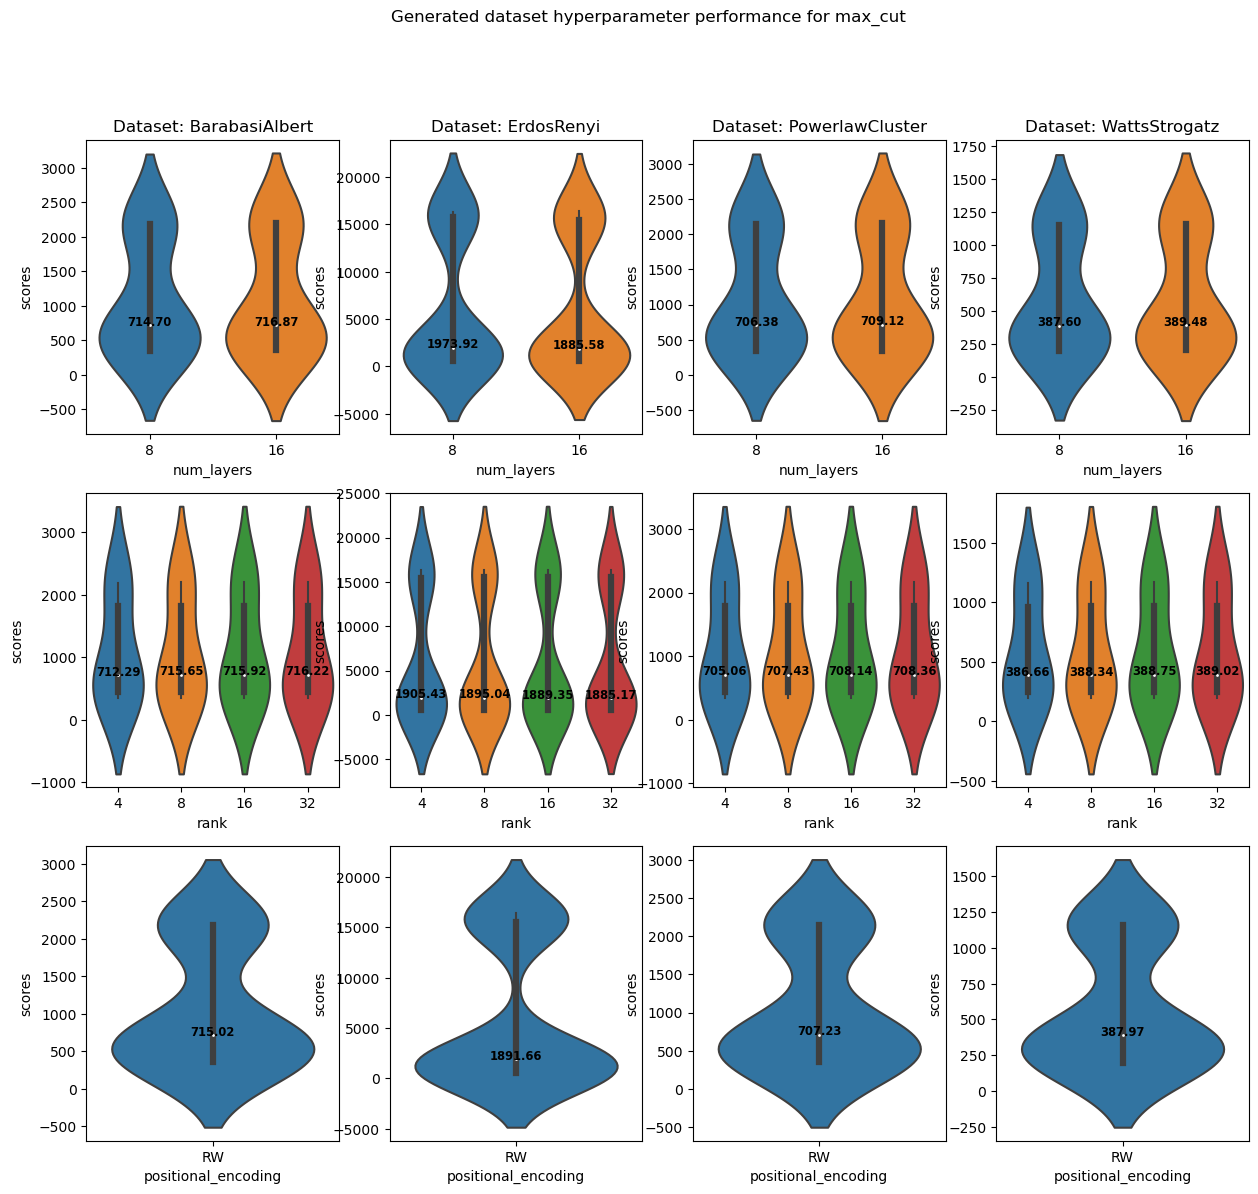

In [9]:
# hparams in rows
# datasets in colums
rows = [x for x in params if x not in ["dataset", 'vc_penalty']]
columns = ['BarabasiAlbert', 'ErdosRenyi', 'PowerlawCluster', 'WattsStrogatz',] #set(df.dataset).union(set("Dummy"))
import matplotlib.pyplot as plt

fig, axs= plt.subplots(nrows=len(rows), ncols=len(columns), figsize=(15, 13))

for i, x in enumerate(columns):
    dfx = df[df.dataset == x]
    if len(dfx) == 0: continue
    for j, y_name in enumerate(rows):
        ax = axs[j][i]
        x_vals = dfx[y_name]
        y_vals = dfx['scores']

        sns.violinplot(x=x_vals, y=y_vals, ax=ax)
        medians = dfx.groupby([y_name])['scores'].median()#
        try:
            median_dict = dict(zip([f'{float(x):0.2f}' for x in medians.keys()], medians.values))
        except:
            median_dict = dict(zip([x for x in medians.keys()], medians.values))
        pos = range(len(medians))
        for tick, label in enumerate(ax.get_xticklabels()):
            try:
                label = f'{float(label.get_text()):0.2f}'
            except:
                label = label.get_text()
            #print(median_dict)
            #if median_dict.get(label, None) is not None:
            ax.text(pos[tick], median_dict[label] + 0.01, f'{median_dict[label]:0.2f}',
                        horizontalalignment='center',
                        size='small',
                        color='k',
                        weight='semibold')
    
        if j == 0:
            ax.set(title=f"Dataset: {x}")

plt.suptitle(f'Generated dataset hyperparameter performance for {task}')
plt.show()

# hparams in rows
# datasets in colums
rows = [x for x in params if x not in ["dataset", 'vc_penalty']]
columns = set(df.dataset) #set(df.dataset).union(set("Dummy"))
import matplotlib.pyplot as plt

fig, axs= plt.subplots(nrows=len(rows), ncols=len(columns), figsize=(15, 13))

for i, x in enumerate(columns):
    dfx = df[df.dataset == x]
    if len(dfx) == 0: continue
    for j, y_name in enumerate(rows):
        ax = axs[j][i]
        x_vals = dfx[y_name]
        y_vals = dfx['scores']

        sns.violinplot(x=x_vals, y=y_vals, ax=ax)
        medians = dfx.groupby([y_name])['scores'].median()#
        try:
            median_dict = dict(zip([f'{float(x):0.2f}' for x in medians.keys()], medians.values))
        except:
            median_dict = dict(zip([x for x in medians.keys()], medians.values))
        pos = range(len(medians))
        for tick, label in enumerate(ax.get_xticklabels()):
            try:
                label = f'{float(label.get_text()):0.2f}'
            except:
                label = label.get_text()
            #print(median_dict)
            #if median_dict.get(label, None) is not None:
            ax.text(pos[tick], median_dict[label] + 0.01, f'{median_dict[label]:0.2f}',
                        horizontalalignment='center',
                        size='small',
                        color='k',
                        weight='semibold')
    
        if j == 0:
            ax.set(title=f"Dataset: {x}")

plt.show()

# hparams in rows
# datasets in colums
rows = [x for x in params if x not in ["dataset", 'vc_penalty']]
columns = {'RANDOM', 'Dummy'} #set(df.TUdataset_name).union(set("Dummy"))
import matplotlib.pyplot as plt

fig, axs= plt.subplots(nrows=len(rows), ncols=len(columns), figsize=(15, 13))

for i, x in enumerate(columns):
    dfx = df[(df.dataset == x)& (df.positional_encoding != "None")]
    if len(dfx) == 0: continue
    for j, y_name in enumerate(rows):
        ax = axs[j][i]
        x_vals = dfx[y_name]
        y_vals = dfx['scores']

        sns.violinplot(x=x_vals, y=y_vals, ax=ax)
        medians = dfx.groupby([y_name])['scores'].median()#
        try:
            median_dict = dict(zip([f'{float(x):0.2f}' for x in medians.keys()], medians.values))
        except:
            median_dict = dict(zip([x for x in medians.keys()], medians.values))
        pos = range(len(medians))
        for tick, label in enumerate(ax.get_xticklabels()):
            try:
                label = f'{float(label.get_text()):0.2f}'
            except:
                label = label.get_text()
            #print(median_dict)
            #if median_dict.get(label, None) is not None:
            ax.text(pos[tick], median_dict[label] + 0.01, f'{median_dict[label]:0.2f}',
                        horizontalalignment='center',
                        size='small',
                        color='k',
                        weight='semibold')
    
        if j == 0:
            ax.set(title=f"Dataset: {x}")

plt.show()